In [43]:
import pathlib

import hydra
import torch
from captum.attr import Occlusion
from torchvision.transforms import Compose
from captum.attr import visualization as viz

from tr_learn.data.dataset import PlateDataset
from tr_learn.model import PlateClassification
from tr_learn.utils import load_infer_info, remap_lighting_keys

In [24]:
config_path = pathlib.Path("exp", "cls_training", "config.yaml")

In [25]:
infer_info = load_infer_info(str(config_path))

In [26]:
config = infer_info.config

In [27]:
num_norm_transforms = len(config.transforms.normalize_transform)

In [28]:
last_norm_transforms = Compose(hydra.utils.instantiate(config.datamodule.predict_load_info.transforms[0]._args_[-num_norm_transforms:]))
config.datamodule.predict_load_info.transforms[0]._args_ = config.datamodule.predict_load_info.transforms[0]._args_[:-num_norm_transforms]

In [29]:
config.datamodule.valid_load_info.transforms[0]._args_ = config.datamodule.valid_load_info.transforms[0]._args_[:-num_norm_transforms]

In [30]:
config.datamodule.predict_load_info.batch_size = 1
config.datamodule.predict_load_info.num_workers = 0

In [31]:
config.datamodule.valid_load_info.batch_size = 1
config.datamodule.valid_load_info.num_workers = 0

In [32]:
datamodule = hydra.utils.instantiate(config.datamodule)

In [33]:
datamodule.setup("predict")

In [34]:
class_mapping = PlateDataset.get_label_mapping()

classes = [""] * len(class_mapping)

for label, index in class_mapping.items():
    classes[index] = label

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [36]:
model: PlateClassification = hydra.utils.instantiate(config.model)
model.eval()
model.to(device);

In [37]:
model.load_state_dict(remap_lighting_keys(torch.load(infer_info.checkpoints[0].file_path, map_location=device)))

<All keys matched successfully>

In [38]:
test_loader = datamodule.predict_dataloader()

In [44]:
explain_method = Occlusion(model)

In [54]:
def explain(explainer, batch, last_transform, device, classes):
    assert batch[0].shape[0] ==  1, "Expected one sample only"
    images = batch[0].to(device)
    input = last_transform(images)

    with torch.inference_mode():
        predicted_logits = model(input)
        scores = model.pos_prob(predicted_logits).cpu()
        predicted_label = model.predict_class(predicted_logits, 0.8).cpu()
        label = predicted_label.item()

    attr = explainer.attribute(input,
                               sliding_window_shapes=(3, 16, 16),
                               strides = (3, 8, 8)
                               ).cpu()

    return images.cpu(), [f"{classes[label]} Conf: {abs(1 - label - score.item()):.2%}" for index, score in zip(predicted_label, scores)], attr 

In [55]:
def show_pred(image, pred_label, attr_map):
    signs = {"original_image": "all",
         "heat_map": "positive",
         "blended_heat_map": "all",
    }

    methods = list(signs.keys())

    _ = viz.visualize_image_attr_multiple(attr_map[0].permute(1, 2, 0).numpy(),
                                image[0].permute(1, 2, 0).numpy(),
                                methods=methods,
                                signs=list(signs.values()),
                                titles=[pred_label[0]] + methods[1:],
                                show_colorbar=True,
                                outlier_perc=1)

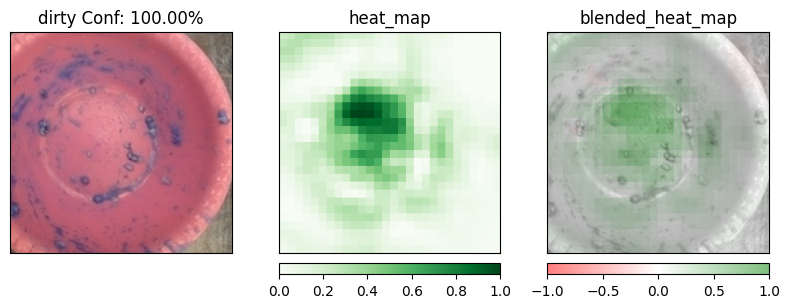

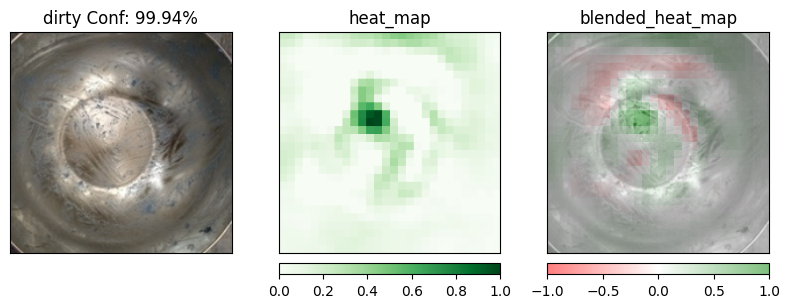

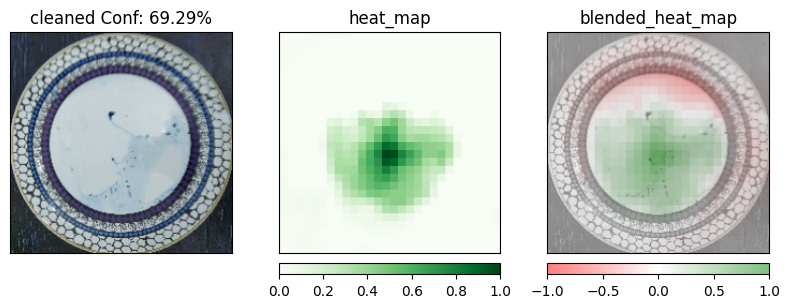

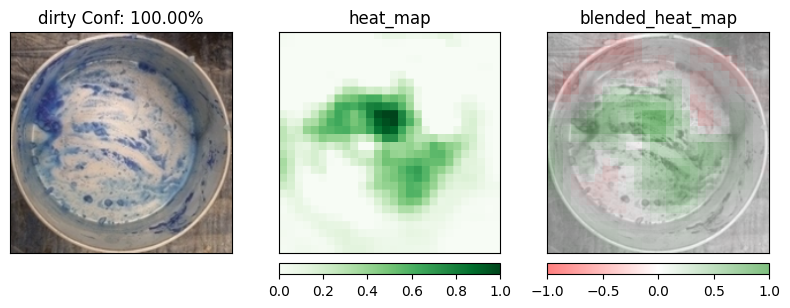

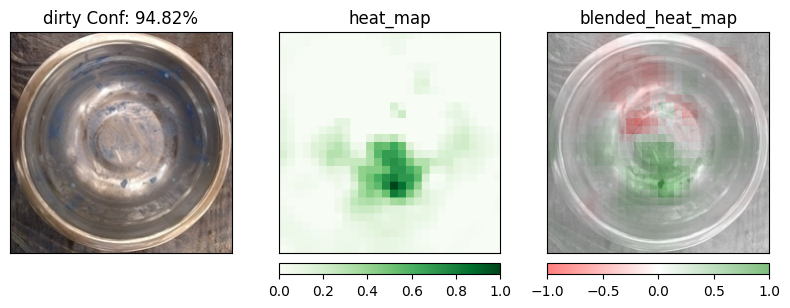

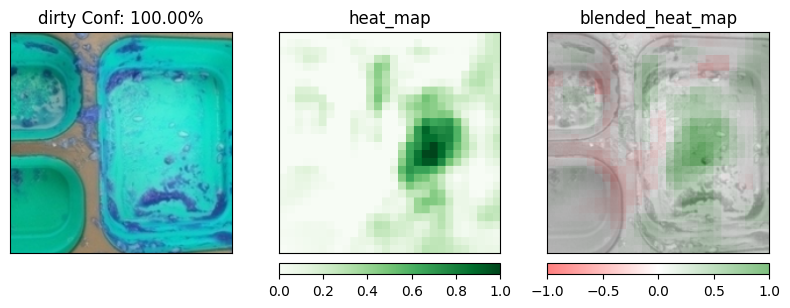

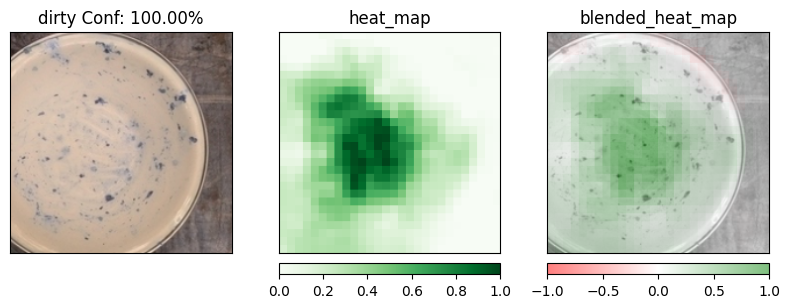

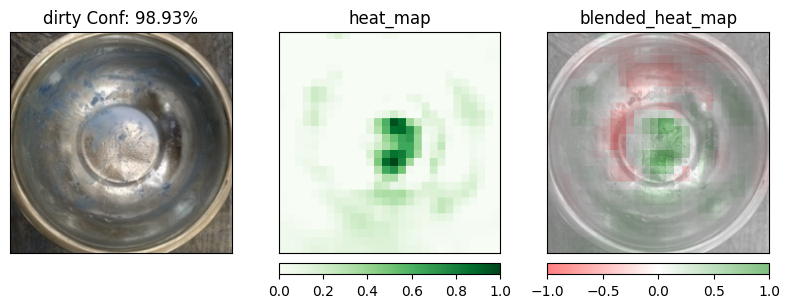

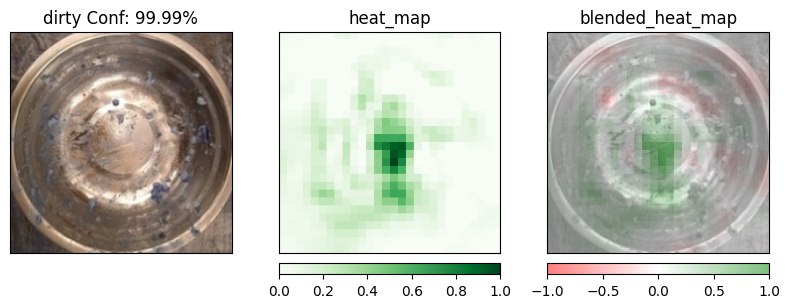

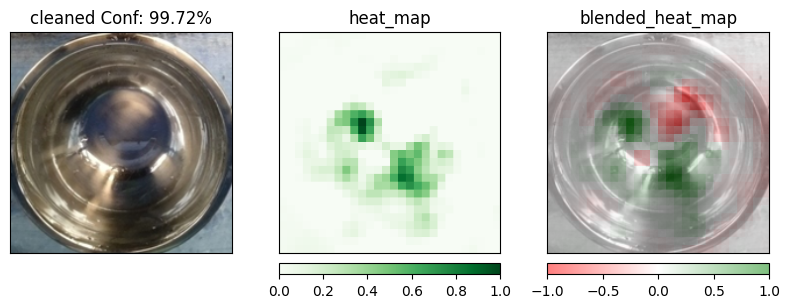

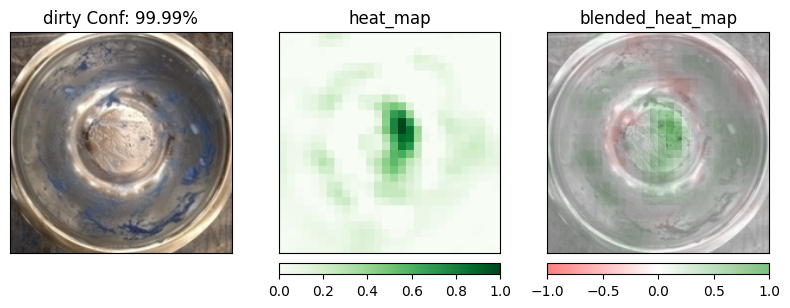

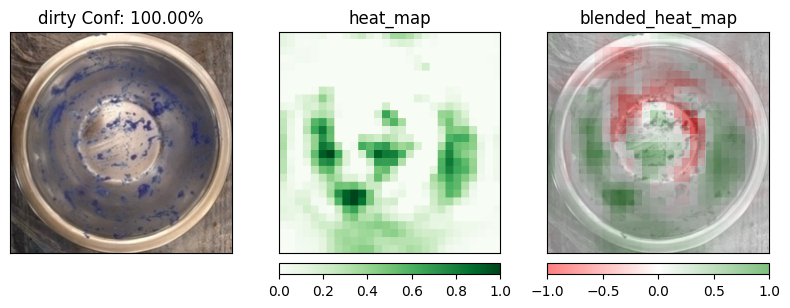

In [56]:
for i, batch in enumerate(test_loader):
    images, pred_labels, attr_map = explain(explain_method, batch, last_norm_transforms, device, classes) 

    show_pred(images, pred_labels, attr_map)
    
    if i > 10:
        break